# Example of genomic data for dimensionality reduction

This notebook demonstrates how deep learning algorithms are used for dimensionality reduction of genomic data in order to automatically cluster cells. We used 4,645 cell samples from 19 patients corresponding to expression profiling by high throughput sequencing as single cell RNA-seq of melanoma tumors. This data is publicly available at the Gene Expression Omnibus repository with the GEO accession number [GSE72056](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056).

## Step 1: Import libraries

The selected framework in this example is [Pytorch](https://pytorch.org/), for this reason we import its components and set the datetime module.

In [1]:
#Import libraries
import torch
import os
import time
from datetime import datetime
from pytz import timezone
import copy
import torchvision
import torch.nn as nn
import torch.optim as optim 
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
my_timezone = timezone('Chile/Continental')
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from ae.train import TrainerAE
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

#Training on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("selected: ",device)

selected:  cpu


## Step 2: Define constants

In [2]:
#Arguments
class Args:
    batch_size = 128
    num_epochs = 5000
    lr = 1e-5 #learning rate
    patience = 200
    latent_dim = 32
    in_dim = 23686 #dimension

args = Args()

In [3]:
#Dataset class
class CustomDataLoader(object):
    def __init__(self, data, ids):
        self.data = data
        self.ids = ids
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.ids[index]

In [4]:
#Build and return the train and test dataloaders
def get_data(path, batch_size):
    data = pd.read_csv(path, sep='\t', index_col=0).T
    ids = data.index.values
    
    #splitting train and test sets into 80%/20% respectively.
    x_train, x_test, ids_train, ids_test = train_test_split(data.values, ids, test_size=0.2, random_state=42)
    
    #generating dataloaders
    dataloader_train = DataLoader(CustomDataLoader(x_train, ids_train), batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(CustomDataLoader(x_test, ids_test), batch_size=batch_size, shuffle=False)
    return dataloader_train, dataloader_test

## Step 3: Load data

The input is a matrix file with the gene expression values for each cell.

In [5]:
dataloader_train, dataloader_test = get_data(path='input_GenomicExample.txt', batch_size=args.batch_size)

## Step 4: Train the model

We define the autoencoder network in the [ae folder](https://github.com/mvidal02/DLexamplesCancer/tree/master/ae). We train with three different optimizer (Adam, SGD and RMSprop) with two different learning rate (1e-3 and 1e-5).

In [6]:
#measure time
start_time = time.time()
since = time.time()

#call autoencoder class and train data
ae = TrainerAE(args, dataloader_train, dataloader_test, device)
ae.train()
ae.load_weights()

#show time elapsed
print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Training Autoencoder... Epoch: 0, Loss: 1.807
Testing Autoencoder... Epoch: 0, Loss: 1.79
Training Autoencoder... Epoch: 50, Loss: 1.751
Testing Autoencoder... Epoch: 50, Loss: 1.73
Training Autoencoder... Epoch: 100, Loss: 1.684
Testing Autoencoder... Epoch: 100, Loss: 1.68
Training Autoencoder... Epoch: 150, Loss: 1.636
Testing Autoencoder... Epoch: 150, Loss: 1.64
Training Autoencoder... Epoch: 200, Loss: 1.597
Testing Autoencoder... Epoch: 200, Loss: 1.61
Training Autoencoder... Epoch: 250, Loss: 1.559
Testing Autoencoder... Epoch: 250, Loss: 1.58
Training Autoencoder... Epoch: 300, Loss: 1.534
Testing Autoencoder... Epoch: 300, Loss: 1.55
Training Autoencoder... Epoch: 350, Loss: 1.512
Testing Autoencoder... Epoch: 350, Loss: 1.53
Training Autoencoder... Epoch: 400, Loss: 1.488
Testing Autoencoder... Epoch: 400, Loss: 1.51
Training Autoencoder... Epoch: 450, Loss: 1.477
Testing Autoencoder... Epoch: 450, Loss: 1.5
Training Autoencoder... Epoch: 500, Loss: 1.462
Testing Autoencoder

## Step 5: Evaluate the model

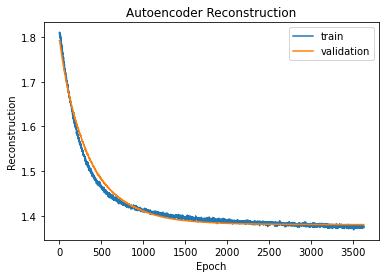

In [7]:
#Funtion to visualize the autoencoder reconstruction
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, label='train')
    plt.plot(np.arange(len(values_t)), values_t, label='validation')
    plt.title('Autoencoder {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')

plot_loss(np.array(ae.reconst), np.array(ae.reconst_t), 'Reconstruction')

## Step 6: Visualize cell clustering

In [8]:
#Function for latent space visualization
def plot_latent_space(x_embedded, labels):
    plt.figure(figsize=(8,6))
    for label in np.unique(labels):
        plt.scatter(x_embedded[:, 0][labels==label], x_embedded[:, 1][labels==label], s=100, marker='.', label=label+1)
    plt.legend()
    plt.show()

In [9]:
ae.model.eval()
latent = []
for x, id_ in dataloader_train:
    x = x.float().to(device)
    z = ae.model.encode(x)
    latent.append(z.cpu().detach())

latent = torch.cat(latent)

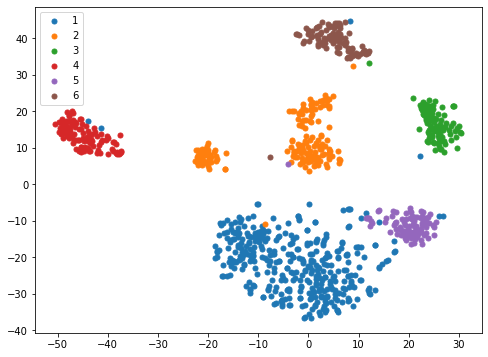

In [10]:
#we further reduced the dimensionality to 2 using t-SNE and agglomerative clustering to visualize the results
s_scores = []
c_labels = []
embeds = []

labels = AgglomerativeClustering(n_clusters=6, connectivity=None).fit_predict(latent)
x_embedded = TSNE(n_components=2).fit_transform(latent)
plot_latent_space(x_embedded, labels)
c_labels.append(labels)
embeds.append(x_embedded)